## Rodrigo Xavier
## Matrícula 569037

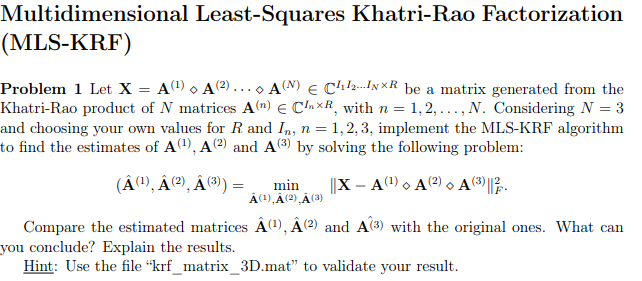

In [1]:
import numpy as np
from typing import Union
from scipy.io import loadmat
from nmse import NMSE
import multilinear_algebra as ma

# Testing with krd_matrix_3D.mat file:
mat_file = loadmat(r"C:\Users\Administrador\Documents\Doutorado\Algebra tensorial\Homeworks\matlab files\krf_matrix_3D.mat")
X = mat_file['X']
A1 = mat_file['A']
A2 = mat_file['B']
A3 = mat_file['C']

print(f'X shape: {X.shape}')
print(f'A1 shape: {A1.shape}')
print(f'A2 shape: {A2.shape}')
print(f'A3 shape: {A3.shape}')

X shape: (160, 4)
A1 shape: (5, 4)
A2 shape: (4, 4)
A3 shape: (8, 4)


In [2]:
# Define dimensions (original dimensions)
I1, I2, I3 = 5, 4, 8
R = X.shape[1] # Number of columns in X
X_hat = np.zeros((I1 * I2 * I3, R))  # Initialize X_hat with correct dimension

# Initialize lists to store the hatimated factor matrices (original dimensions)
A1_hat = np.zeros((I1, R))
A2_hat = np.zeros((I2, R))
A3_hat = np.zeros((I3, R))

# Step 2: For columns r in column range of colums in X
for r in range(R):
    # Step 2.1: Extract the r-th column of X
    x_r = X[:, r]

    # Step 2.2: Tensorize x_r to get X_r 
    X_r = x_r.reshape((I3, I2, I1), order='F')  # Reshape to original tensor form

    # Step 2.3: Compute the HOSVD of X_r
    S, U1, U2, U3 = ma.hosvd(X_r)

    # Step 2.4: Extract and scale the first singular vectors
    y = np.sign(S[0, 0, 0])*(np.abs(S[0, 0, 0]) ** (1/3))
    a1_r = y * U3[:, 0]  # Size I1 (5)
    a2_r = y * U2[:, 0]  # Size I2 (4)
    a3_r = y * U1[:, 0]  # Size I3 (8)

    # Store the results in the hatimated factor matrices
    A1_hat[:, r] = a1_r  
    A2_hat[:, r] = a2_r  
    A3_hat[:, r] = a3_r

# Estimating X_hat from A1_hat A2_hat A3_hat
for r in range(R):
    kr_prod = np.kron(A1_hat[:, r], np.kron(A2_hat[:, r], A3_hat[:, r]))
    X_hat[:, r] = kr_prod.reshape(-1)  # Reshape to a column vector

print(f'Error between X and X_hat: {float(ma.NMSE(X, X_hat))}')

Error between X and X_hat: 3.6196092055916475e-31


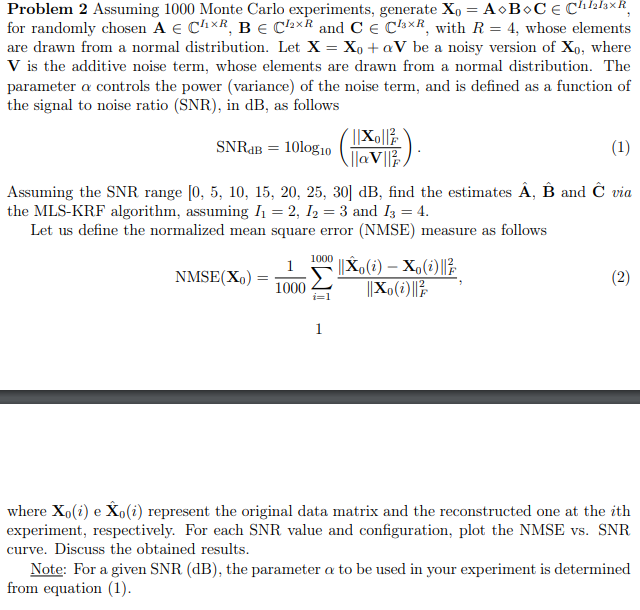

In [3]:
def mlskrf(A1, A2, A3, SNR_dB):
    """
    Performs Multidimensional LS-KRF algorithm.

    Args:
        - A1, A2, A3: Input tensors to generate X (NumPy array)
        - Signal to Noise Ratio value

    Returns:
        X: Tensor of dimensions (I1 * I2 * I3), R constructed from A1, A2, A3, represents original signal
        X_hat: Reconstructed tensor X_hat (NumPy array).
    """
    # Define dimensions (original dimensions)
    I1, I2, I3 , R = A1.shape[0], A2.shape[0], A3.shape[0], A1.shape[1]
    
    # Initialize X
    X = np.zeros((I1 * I2 * I3, R))
    
    # Initialize X_hat with correct dimensions
    X_hat = np.zeros((I1 * I2 * I3, R)) 

    # Estimating X from A1 A2 A3
    for r in range(R):
        kr_prod = np.kron(A1[:, r], np.kron(A2[:, r], A3[:, r]))
        X[:, r] = kr_prod.reshape(-1)  # Reshape to a column vector
    
    # Adding AWGN noise:
    if SNR_dB is not None:
        X = X + ma.alphaV(X, SNR_dB)
    
    X = X.real

    # Initialize lists to store the hatimated factor matrices (original dimensions)
    A1_hat = np.zeros((I1, R))
    A2_hat = np.zeros((I2, R))
    A3_hat = np.zeros((I3, R))

    # Step 2: For columns r in column range of colums in X
    for r in range(R):
        # Step 2.1: Extract the r-th column of X
        x_r = X[:, r]

        # Step 2.2: Tensorize x_r to get X_r 
        X_r = x_r.reshape((I3, I2, I1), order='F')  # Reshape to original tensor form

        # Step 2.3: Compute the HOSVD of X_r
        S, U1, U2, U3 = ma.hosvd(X_r)

        # Step 2.4: Extract and scale the first singular vectors
        y = np.sign(S[0, 0, 0])*(np.abs(S[0, 0, 0]) ** (1/3))
        a1_r = y * U3[:, 0]  # Size I1 (5)
        a2_r = y * U2[:, 0]  # Size I2 (4)
        a3_r = y * U1[:, 0]  # Size I3 (8)

        # Store the results in the hatimated factor matrices
        A1_hat[:, r] = a1_r  
        A2_hat[:, r] = a2_r  
        A3_hat[:, r] = a3_r

    # Estimating X_hat from A1_hat A2_hat A3_hat
    for r in range(R):
        kr_prod = np.kron(A1_hat[:, r], np.kron(A2_hat[:, r], A3_hat[:, r]))
        X_hat[:, r] = kr_prod.reshape(-1)  # Reshape to a column vector

    return X, X_hat

In [4]:
I1, I2, I3, R = 2, 3, 4, 4
SNR_dB_range = [0, 5, 10, 15, 20, 25, 30]
num_experiments = 1000

# Run simulations for the first set of parameters (I1, J1, P1, Q1)
nmse_results1 = np.zeros((num_experiments, len(SNR_dB_range)))
for ind_run in range(num_experiments):
    for snr_idx, snr in enumerate(SNR_dB_range):
        A1 = np.random.randn(I1, R)
        A2 = np.random.randn(I2, R)
        A3 = np.random.randn(I3, R)
        X, X_hat = mlskrf(A1, A2, A3, snr)
        nmse_results1[ind_run, snr_idx] = NMSE(X, X_hat)

# Take the mean of the independent runs (for the first set)
nmse_results1 = nmse_results1.mean(axis=0)

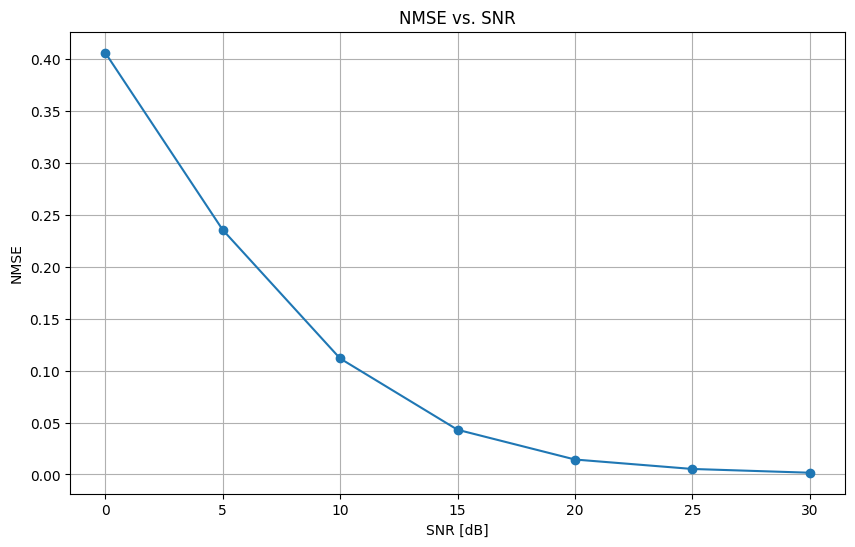

In [5]:
import matplotlib.pyplot as plt

######## ######## ########
# Plotting
_ = plt.figure(figsize=(10,6))  # Create a new figure for clarity

# Plot results for the first set of parameters (I1, J1, P1, Q1)
plt.plot(SNR_dB_range, nmse_results1, marker='o')

plt.grid(True, which="both")
plt.xlabel("SNR [dB]")
plt.ylabel("NMSE")
plt.title("NMSE vs. SNR")
plt.show()